# GSS Data Analysis: Modeling

# Part 1: Cleaning the data

The data currently comes in an all numeric format, making visuals and understanding the data difficult. Additionaly, all NAs seem like actual values. Cleaning the data is the first step in analysis.

## Step One: Converting the data to and from Strings

We can use the metadata included with the data download to easily remap strings to numbers and back.

In [98]:
import numpy as np
import pandas as pd 
from function_package import (recur_dictify, DataFrameSelector, BinaryEncoding, DataFrameSelector,
                     UniqueThreshold, FilterNAs, DataFrameSelectorAndRecode, QuickModel)

In [2]:
# Loading in the data

df = pd.read_csv('data/GSS.csv')

In [3]:
# Using the meta data as a tool for converting the numeric values of the df into strings and then back

df_remap  = pd.read_excel('data/GSS_metadata.xlsx',sheet_name='Codes')
df_remap = df_remap.iloc[:,1:]
df_remap = df_remap.fillna(method='ffill')
df_remap['Variable Name'] = df_remap['Variable Name'].str.upper()

In [4]:
# This dataframe will help turn the strings back into numbers
# This will help speed up recoding ordinal values for machine learning

df_remap_reverse = df_remap[['Variable Name','Label','Code']]

In [5]:
remaper = recur_dictify(df_remap)
remaper_reverse = recur_dictify(df_remap_reverse)

In [6]:
# Converts the numbers to strings and drops NAs

df_strings = df.replace(remaper)
df_strings = df_strings.replace(["No answer","Don't know","Not applicable","-1"],np.NaN)
# df_strings.to_csv('data/data_strings.csv', index=False)
df_strings = pd.read_csv('data/data_strings.csv', low_memory=False)

In [7]:
# We must be more specific to convert strings back into numbers
# This is because the pandas 'replace' function fails for the 'remaper_reverse' dictionary

df = df_strings
for key in remaper_reverse.keys():
    df[key] = df_strings[key].map(remaper_reverse[key]).fillna(df_strings[key])

# df.to_csv('data/data_clean.csv', index=False)

## Step Two: Determining what is categorical/ordinal

__**Current Assumptions**__

* Ordinals are scaled, assumed to be continous. Every column that has more than 11 distinct values (with many execptions) is considered to be ordinal/continous

__**Gotchas**__

* helpful,fair,trust,age (considered ordinal) - 3 to 2
    * Image from metadata explains the problem: ![3 to 2](data/img/2-3_Switch.png)
* Premarsx, teensex, xmarsex, homosex, bible - 'other' trouble
    * 'other' appears to not be entered within the data after 2000
* Nominal attributes under 11 - spjewaj, sprel?, relig16?, denom16?, relig?, parborn, race, sector, dipged, pawrkslf, spwrksta, marital, wrkstat, region
    * presidental - i.e. vote12,pres12,if12who,...
* tax - R pays none<vol.>/4
    * 'R pays none<vol.>/4' appears to not be entered within the data after 2000
* ordinal w/ large amount of categories - rincom06,rincome,income
* Drop: ID, dateinv, cohort: these are primarly for record keeping purposes
* 'SPOTHER','OTH16','OTHER' appear to strings

#### Getting the column names of the Nominal, Ordinal (coded as Continuous), and Binary columns

In [8]:
# We operate under the tested assumption that unless specified or over 11 distinct values,
# the column is ordinal.

# We end up with four distinct lists of columns that we will use in our data pipeline:
# Ordinal, Nominal, Binary, and Drop

# Note: We in fact will not use the Drop list in the pipelines, as we will just not select these columns


def GetColumnNames(df, Target_Variables = ['POLVIEWS']):
    '''Simply uses our dataframe and makes a list of the nominal, ordinal, and binary columns.'''
    
    # Gets the dataframe column names alongisde the number of unique entries
    # Forms the basis of our rule system: if over 11 distinct categories then it is nominal
    df_columns = df.nunique()

    # Columns that may become exceptions to the rules
    Drop = ['ID_','DATEINTV','COHORT','SPOTHER','OTH16','OTHER']
    Continuous = ["YEAR","HRS1","HRS2","AGEWED","SPHRS1","SIBS","CHILDS","AGE","WHENHS","WHENCOL",
             "HOMPOP","CHLDIDEL","COHORT","BABIES","PRETEEN","TEENS","TVHOURS",'WEEKSWRK']
    Small_Categorical = ["REGION","WRKSTAT","MARITAL",'SPWRKSTA','PAWRKSLF','DIPGED','SECTOR','RACE','PARBORN',
                        'PRES00','VOTE04','PRES04','IF04WHO','VOTE00','VOTE08','PRES08',
                        'IF08WHO','VOTE12','PRES12','IF12WHO']
    Large_Ordinal = ['RINCOM06','RINCOME','INCOME']

    # Gets rid of all of the columns manually specified
    df_columns = df_columns[~(df_columns.index.isin(Drop)) &
                       ~(df_columns.index.isin(Continuous)) &
                       ~(df_columns.index.isin(Small_Categorical)) &
                       ~(df_columns.index.isin(Large_Ordinal)) &
                       ~(df_columns.index.isin(Target_Variables))]

    # Now we make the lists of columns one by one
    Nominal = list(df_columns[df_columns >= 11].index & df_columns[df_columns != 2].index)
    Nominal = Nominal + Small_Categorical
    # Checks to see if all of the list items are in the column index of the Df. If not, drop them.
    Nominal = [col for col in Nominal if col in df.columns]
    
    Ordinal = list(df_columns[df_columns <= 11].index & df_columns[df_columns != 2].index) 
    Ordinal = Ordinal + Continuous + Large_Ordinal
    Ordinal = [col for col in Ordinal if col in df.columns]
    
    Binary = list(df_columns[df_columns == 2].index)
    Binary = [col for col in Binary if col in df.columns]
    
    return Nominal, Ordinal, Binary

In [9]:
df = pd.read_csv('data/data_clean.csv',low_memory=False)

# Uses our freshly made function to get column names
Nominal, Ordinal, Binary = GetColumnNames(df)

# Replacing 2 with 3
change_cols = ['HELPFUL','FAIR','TRUST','AGE']
df[change_cols] = df[change_cols].replace(3,786)
df[change_cols] = df[change_cols].replace(2,3)
df[change_cols] = df[change_cols].replace(786,2)

## Step Three: Pipelines

In order to automate the preprocessing steps, we will use sklearn's pipelines. Not only does this lead to less errors, but we can go back and make modifications as necessary. Note, here we automatically get rid of records that are before 2000.

In [10]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

### DataFrame Pipeline

In [11]:
# First, let's only include enteries after 1999 and where POLVIEWS is not NA
df_filtered = df[(df['YEAR'] >= 2000) & ~(np.isnan(df['POLVIEWS']))]

# Second let's use the polviews as the primary variable
X_df = df_filtered.drop('POLVIEWS', axis = 1)
y = df_filtered['POLVIEWS']

In [12]:
# We can make a small pipeline to implement changes
df_pipeline = Pipeline([
    ('drop_categoricals', UniqueThreshold(threshold = 10, ignore_columns=Ordinal)),
    
    # Note: Threshold means that all columns with a NaN ratio of below 'threshold' will be kept
    ('drop_NAs', FilterNAs(threshold = .8))
])

In [13]:
# Apply the DataFrame Pipeline
X = df_pipeline.fit_transform(X_df)

# Get new column names
Nominal, Ordinal, Binary = GetColumnNames(X)

### Numpy Array Pipeline

In [14]:
# Due to the way pipelines are implemented, we must respecify our pipelines if an arguement changes

ordinal_pipeline = Pipeline([
    ('selector', DataFrameSelector(Ordinal)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('selector', DataFrameSelectorAndRecode(Nominal,remaper)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encode', OneHotEncoder(categories='auto'))
])

binary_pipeline = Pipeline([
     ('selector', DataFrameSelector(Binary)),
     ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('binary', BinaryEncoding())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('nom_pipe', nominal_pipeline),
    ("ord_pipe", ordinal_pipeline),
    ('bin_pipe', binary_pipeline)
])

In [15]:
# Now we put it through the Numpy Array Pipeline
X = full_pipeline.fit_transform(X_df)

In [16]:
X.shape

(20602, 270)

In [17]:
# Note: The output of a pipeline is a Numpy array, which cannot have column names.
# Now that we confirmed the dataframe is of an acceptable size, we can turn the Numpy array back into a DataFrame.

ordinal_col_names = list(np.asarray(Ordinal))
nominal_col_names = list(np.hstack((nominal_pipeline.named_steps['encode'].categories_)))
binary_col_names = list(np.asarray(Binary))
attributes = np.concatenate([nominal_col_names,ordinal_col_names,binary_col_names])
X = pd.DataFrame(X.toarray(),columns=attributes)

In [45]:
# After imputation

X.FEAR.value_counts()

1.0    16291
0.0     4311
Name: FEAR, dtype: int64

In [46]:
# Before imputation

df_filtered.FEAR.value_counts()

2.0    8315
1.0    4311
Name: FEAR, dtype: int64

### Aside: Dummy Variable Reference Category

When we use Least Sqaures or Maximum Likelihood Estimation, we must leave a reference category. Other machine learning models can keep this reference category. Therefore, we will make a special X set with a reference category for our linear modeling with a slight modification to our pipelines. Note, while it seems as though Sklearn does not have an easy dummy encoding w/ reference, Pandas has an easy function we can apply.

In [20]:
# Here we get a list of all of the unqiue categories
# In this manner we can backtrack our dummy encoding and drop a column
# In this case, we drop the last dummy encoded column as a reference

ref = X_df[Nominal]
ref = ref.fillna(method='ffill')
ref = ref.fillna(method='bfill')
ref = ref.nunique()

In [21]:
# Here we create a list of the indexed columns to drop thru a running sum of distinct values
# Note we start at -1, as indexing starts a zero

running_sum = -1
drop_list = []

for i in ref.values:
    running_sum += i
    drop_list.append(running_sum)

In [22]:
reference_categories = X.iloc[:,drop_list].columns
X_reference = X.drop(reference_categories, axis = 1)
reference_categories_labels = {i[0]: i[1] for i in zip(Nominal, reference_categories.values)}

print('Reference categories are: {}'.format(reference_categories_labels))

Reference categories are: {'REGION': 'W. sou. central', 'WRKSTAT': 'Working parttime', 'MARITAL': 'Widowed', 'SPWRKSTA': 'Working parttime', 'PAWRKSLF': 'Someone else', 'DIPGED': 'Other', 'RACE': 'White', 'PARBORN': 'Not mother;fa.dk', 'VOTE04': 'Voted', 'PRES04': 'Nader', 'VOTE00': 'Voted', 'VOTE08': 'Voted', 'PRES08': 'Other candidate (specify)', 'VOTE12': 'Voted'}


### Data Cleaning Outcomes

Now our data is fully clean and ready for machine learning algorithms, however we should be careful of the assumptions that we have made and the final shape of the data.

Note that we have made a large amount of simple imputations, such as FEAR: ![Imputation](data/img/Imputation.png)

This may be adverse in the long-run, as we know that assuming all of those who did not answer choose the most popular option will not have good accuracy. We may have to be more selective in the columns we keep or use more complex imputation methods in the future.

# Part 2: Modeling

First, we will try to predict POLVIEWS.

### Helper Function: Quick Fitting Multiple Models

In [23]:
# We use statsmodels to get the p-values
import statsmodels.api as sm
from sklearn.linear_model import Lars, Ridge, Lasso, ElasticNet 

## Step One: Linear Models

Linear models are some of the most simple and interpretable models. We start with pure linear regression. Given that we have over 300 variables, we know that many will not be correlated with POLVIEWS. Linear regression tends to be greedy in variable selection, so we used more generalized models for variable selection. 

After linear regression, we do least angle regression, which is very similar stepwise regression. Then, we use Ridge, Lasso, and ElasticNet in order to lower the amount of 'noise' variables that our basic linear model has. Note that we will use cross validation.

### Linear Regrssion

#### Running the Model

In [24]:
# We must reset our index, or the linear model will fail
X_reference = X_reference.reset_index(drop=True)
y_reference = y.reset_index(drop=True)

# We must add a constant manually, as the linear model will not add one automatically
X_model = sm.add_constant(X_reference)

In [25]:
model = sm.OLS(y_reference,X_model)
model = model.fit()
# model.summary() Long Output
print('R-Sqaured:', model.rsquared)

R-Sqaured: 0.36075096584375166


In [26]:
model_summary = pd.DataFrame({'Beta':model.params,'P-Value':model.pvalues})
model_summary.sort_values('P-Value', inplace=True)

# The lowest 20 variables in terms of p-value.
model_summary[model_summary['P-Value'] <= .05][:20]

Beta        P-Value
PARTYID   0.355964  1.318975e-264
const     3.082136   1.739679e-15
EQWLTH    0.085234   7.075301e-13
CAPPUN   -0.137560   6.083830e-12
GRASS     0.152513   2.512404e-11
HOMOSEX  -0.076947   3.324028e-11
NATARMS  -0.056600   1.694503e-10
CONLABOR  0.057868   1.931208e-10
Black     0.175395   6.915570e-09
PILLOK    0.047514   2.557423e-07
TAX      -0.044327   1.926125e-06
NATCRIMY -0.046570   2.662658e-06
WRKWAYUP -0.050807   6.221347e-06
RELITEN  -0.046455   1.119004e-05
PORNLAW  -0.041075   1.137524e-05
NATENVIY  0.044013   1.248902e-05
CONARMY  -0.044269   1.458076e-05
CONPRESS  0.040386   2.725853e-05
SEXEDUC   0.158935   2.882922e-05
NATARMSY -0.036427   3.287843e-05

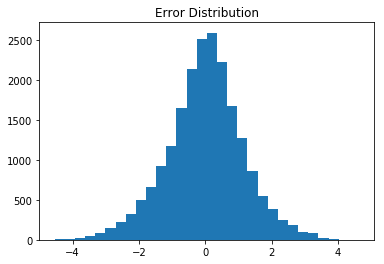

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(model.resid, bins=30)
ax.set_title('Error Distribution')
plt.show()

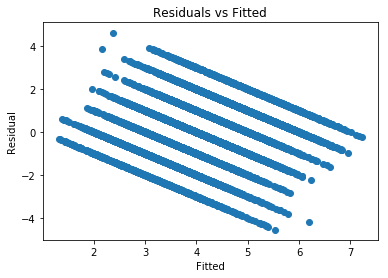

In [28]:
fig, ax = plt.subplots()
ax.scatter(model.fittedvalues,model.resid)
ax.set_xlabel('Fitted')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted')
plt.show()

#### Linear Regression Overview

The R-Sqaured for the linear model is .364 on the training data. 

While our linear model does tell us some interesting patterns, we should take a look at the assumptions that were violated in the model. We can see that our error is normally distributed with a mean of zero, but we do not have homoscedasticity in our errors. There appears to be systematic bias, and the relationship between the target variable and the predictors is likely not linear. Also, one could also say that using the 'PARTYID' variable should be removed when predicting due to the innate correlianity with 'POLVIEWS'. The bias found in the Residuals vs Fitted chart also calls into question whether we should use the target variable as a continuous variable, or change it to categorical. We can experiment with different models later.

Looking past the violated assumptions, we can generate some hypotheses about the data. While we will not have a lot of confidence with these hypotheses, they can set the baseline for hypotheses in the future. The main hypothesis is that: While holding everything else equal the following variables are significant predictors of a person's political status:
* WRKSLF (Respondent self-emp or works for somebody)
* RACE (Black, White, or Other)
* MARITAL (Marital Status)
* EQUAL (Should government try to equalize wealth gap?)
* CAPPUN (Favor or Oppose death penalty)
* CONLABOR (Does respondent have confidence in the people in the leaders of industry)

In terms of tying this into our problem of advising a politician during a run for office, we could derive great value from proving this hypothesis. We could see that a liberal type of candidate could find great support with other liberals if she/he strong opposes income inequality and and the death penalty at the cost of losing popularity with moderates and conservatives. If one were running a presidential campiagn, one could emphasize these typically liberal views during the run to get onto the presidential ticket and then shift to more moderate views after to appease the moderates. One can also use these relationships as a tool to segregate liberals, conservatives, and moderates in targeted advertising campaigns. 

### More Linear Models

#### Quick Modeling with Cross Validation

In [29]:
# Now we can test out the more advanced regression models

test_models = [Lars(eps=15), Ridge(), Lasso(max_iter=15), ElasticNet()]
test_model_names = ['Lars','Ridge','Lasso','ElasticNet']
QuickModel(test_models,test_model_names,X,y)

Lars Cross Validation: [0.01742255 0.01809097 0.02028363 0.02431995 0.02382228]
Ridge Cross Validation: [0.24624823 0.31735218 0.32442218 0.37727894 0.3886654 ]
Lasso Cross Validation: [-1.88579591e-06 -3.26802226e-07 -5.57022686e-04 -4.38629753e-04
 -1.17178957e-05]
ElasticNet Cross Validation: [0.0460751  0.04764606 0.04504328 0.04437528 0.04342092]


On models with defaults, the best model in terms of Rsqaured is ridge regression. On some folds however, it performs worse than the regular regression. Let's experiment with the penalty of the ridge,elasticc, and lasso of the regression in order to see if we can get better results.

#### Grid Search

In [30]:
# import joblib

# from sklearn.model_selection import GridSearchCV

# # L1 Penality (ie error + alpha * sum of all betas)
# lasso_params = {'alpha': [.005,.3,.5, 1, 5, 10, 15, 50]}

# # L2 Penality (ie error + alpha * sum of all betas^2)
# ridge_params = {'alpha': [10]}
 

# elastic_params = {
#     'alpha': [.5, 1,15, 50,100,200,300,400],
#     'l1_ratio' : [.7,.5,.3,.2,.1,.05]
# }

# Takes a while to run. I elect to dump to a pickle and load back out to save time.
# ridge_search = GridSearchCV(Ridge(),ridge_params,cv=5).fit(X,y)
# lasso_search = GridSearchCV(Lasso(),lasso_params,cv=5).fit(X,y)
# elastic_search = GridSearchCV(ElasticNet(),elastic_params,cv=5).fit(X,y)

# joblib.dump(ridge_search, "data/models/ridge_model.pkl")
# joblib.dump(lasso_search, "data/models/lasso_model.pkl")
# joblib.dump(elastic_search, "data/models/elastic_model.pkl")

In [38]:
ridge_search = joblib.load("data/models/ridge_model.pkl")
lasso_search = joblib.load('data/models/lasso_model.pkl')
elastic_search = joblib.load('data/models/elastic_model.pkl')

In [39]:
print('Ridge:',ridge_search.best_params_,ridge_search.best_score_)
print('Lasso:',lasso_search.best_params_,lasso_search.best_score_)
print('Elastic:',elastic_search.best_params_,elastic_search.best_score_)

Ridge: {'alpha': 500} 0.3428002734775513
Lasso: {'alpha': 0.3} 0.1589181023816902
Elastic: {'alpha': 0.5, 'l1_ratio': 0.05} 0.3169783173969842


The results of the testing clearly show that Ridge regression is far superior to Lasso, and we need a very high penalty.

#### Visualizing the Alphas

Since Lasso and Ridge regression are not too computationally burdensome and only have one hyperparameter, we can generate many different values of the hyperparamter in a single function call.

In [78]:
from sklearn.model_selection import cross_val_score

In [76]:
alphas = np.arange(1,501, 10)

In [86]:
Lasso_scores = [cross_val_score(Lasso(alpha), X, y, cv=3,n_jobs=-1).mean()
                for alpha in alphas]

Ridge_scores = [cross_val_score(Ridge(alpha), X, y, cv=3,n_jobs=-1).mean()
                for alpha in alphas]

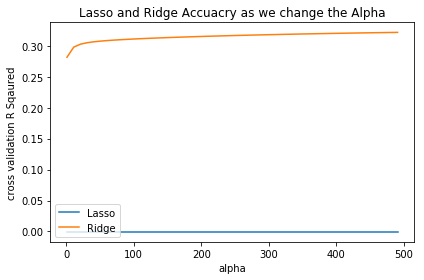

In [93]:
plt.plot(alphas, Lasso_scores, label='Lasso')
plt.plot(alphas, Ridge_scores, label='Ridge')


plt.legend(loc='lower left')
plt.title('Lasso and Ridge Accuracy as we change the Alpha')
plt.xlabel('alpha')
plt.ylabel('cross validation R Sqaured')
plt.tight_layout()
plt.show()

## Step 2: Decision Tree Techniques and other Non-Linear Models

Decision Tree methods will be useful for not only for prediction, but variable importance and high interpretability will be pretty useful. We can use information based on the assumption that Y is ordinal and Y is categorical.

### Running Trees

#### Evaluating Base Tree Models 

In [41]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
RandomForestClassifier, RandomForestRegressor)

In [104]:
y_cat = OneHotEncoder(categories='auto').fit_transform(y.values.reshape(-1,1)).toarray()

In [99]:
test_models = [DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]
test_model_names = ['Dec Tree','Grad Boost','Random Forest']
QuickModel(test_models,test_model_names,X,y, scoring='r2')

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [109]:
def QuickModel_Cat(ml_algo,names,X,y, scoring = 'r2'):
    '''Quick modeling and cross validation for multiple models'''
    for algo,name in zip(ml_algo,names):
        print(name, 'Cross Validation:', cross_val_score(Model,X,y,cv=5,scoring=scoring))

In [ ]:
test_models = [DecisionTreeClassifier(), RandomForestClassifier(), 
               GradientBoostingClassifier()]
test_model_names = ['Dec Tree','Grad Boost','Random Forest']
QuickModel_Cat(test_models,test_model_names,X,y,scoring ='accuracy')

#### Feature Importance

In [207]:
model = GradientBoostingRegressor()
model = model.fit(X,y)

In [208]:
feature_importance = pd.DataFrame(model.feature_importances_,X.columns)

In [ ]:
feature_importance.sort_values(by=0, ascending=False)[10]

#### Visualizing Trees

In [126]:
model = DecisionTreeClassifier()

estimator = model.fit(X, y)

In [122]:

# from sklearn.tree import export_graphviz
# Export as dot file
# export_graphviz(estimator, out_file='data/models/dec_tree.dot', 
#                 feature_names = X.columns,
#                 class_names = ['1','2','3','4','5','6','7'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'data/models/dec_tree.dot', '-o', 
#       'data/models/dec_tree.png', '-Gdpi=600'])



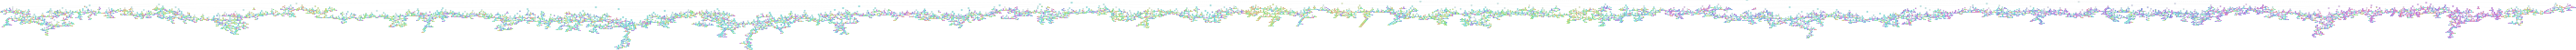

In [125]:
from IPython.display import Image
Image(filename = 'data/models/dec_tree.png')

##### Next Step for image

We need to apply variable selection if we want a more comprehensable tree. Our other machine learning models have generated variables that may be important, we can use only the top variables and see how much our accuracy takes a hit.

## Step 3: Clustering and Profile Generation

In [146]:
cluster_variables = ["polviews","natsci","natenrgy","natenvir" \
                     ,"natrace", "natarms","nataid","natfare",
                     "nathealy","gunlaw","cappun", "courts","helpnot" \
                     ,"helpsick","fejobaff","eqwlth"]

cluster_variables = [i.upper() for i in cluster_variables]

In [143]:
cluster_variables

['polviews',
 'natsci',
 'natenrgy',
 'natenvir',
 'natrace',
 'natarms',
 'nataid',
 'natfare',
 'nathealy',
 'gunlaw',
 'cappun',
 'courts',
 'helpnot',
 'helpsick',
 'fejobaff',
 'eqwlth']

In [129]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [183]:
X_cluster = pd.concat([X.reset_index(drop=True),y.reset_index(drop=True)]
                      , axis=1)
X_cluster_variables = X_cluster[cluster_variables]

In [184]:
kmeans_cluster = KMeans(n_clusters=4, n_jobs = -1)
hier_cluster = AgglomerativeClustering(n_clusters=4)

In [185]:
kmeans_cluster = kmeans_cluster.fit(X_cluster_variables)

In [205]:
hier_cluster = hier_cluster.fit(X_cluster_variables)

In [ ]:
df_clus = df.copy()

In [188]:
df_clus = df[(df['YEAR'] >= 2000) & ~(np.isnan(df['POLVIEWS']))]

In [189]:
df_clus.insert(len(df_filtered.columns), 'kmeans', kmeans_cluster.labels_)

In [192]:
df_clus = df_clus.groupby('kmeans').mean()

In [193]:
df_clus['POLVIEWS']

kmeans
0    4.757024
1    5.469887
2    3.456140
3    3.447906
Name: POLVIEWS, dtype: float64

In [204]:
# Note: Higher polviews means more coservitive, higher gunlaw means oppose gun permits,
# Race: Lower means more white

df_clus[['POLVIEWS','SEX','RACE','HRS1','AGE','BABIES','RINCOM06','GUNLAW']]

POLVIEWS       SEX      RACE       HRS1        AGE    BABIES  \
kmeans                                                                 
0       4.757024  1.464313  1.269932  42.322745  49.697905  0.194721   
1       5.469887  1.525667  1.197858  42.492271  50.845967  0.161323   
2       3.456140  1.575342  1.479452  40.728466  45.254822  0.184287   
3       3.447906  1.576927  1.349814  41.822563  46.345871  0.179487   

         RINCOM06    GUNLAW  
kmeans                       
0       16.072115  1.319284  
1       16.308499  1.323968  
2       14.565332  1.167732  
3       15.260450  1.185057